# 영화 리뷰 평점 예측 모델 구축

## 데이터 전처리

### 필요한 패키지 임포트

In [275]:
import pandas as pd
import re

In [276]:
from keras.datasets import reuters
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding 
from keras.preprocessing import sequence 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from tensorflow import keras

### 데이터 가져오기

In [277]:
data = pd.read_excel('./영화목록.xlsx') # data = pd.read_excel('./영화목록3_복구.xlsx')
data.head()

,Unnamed: 0,name,num,review
0,0,명량,10,역대 대명작이라 자부합니다^^
1,1,명량,10,진짜 이건 우리나라 영화계에 한 획을 그을 정도에 명작입니다 우리가 역사를 배워야 ...
2,2,명량,3,"국뽕 범벅, 거품, 스크린독점 관객동원"
3,3,명량,10,초등 고학년 아들과 진도에 다녀온후 같이 봣는데 정말 감사하고 감동이며 죄송스러운 ...
4,4,명량,10,"깊게 숨을 들이쉬고 후하고 내뱉은 뒤, 이 영화를 보아라. 다보고 나서 이틀 뒤에 ..."


### 데이터 확인

In [278]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   name        10000 non-null  object
 2   num         10000 non-null  int64 
 3   review      8930 non-null   object
dtypes: int64(2), object(2)
memory usage: 312.6+ KB


### 결측값 처리

In [279]:
data = data[data['review'].notnull()]
data = data[data['num'].notnull()]

In [280]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8930 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8930 non-null   int64 
 1   name        8930 non-null   object
 2   num         8930 non-null   int64 
 3   review      8930 non-null   object
dtypes: int64(2), object(2)
memory usage: 348.8+ KB


In [281]:
data.tail()

,Unnamed: 0,name,num,review
9994,9994,블랙 팬서,10,나의 영원한 왕 영원한 히어로..이제 하늘을 지키기위해 갔다고 생각할래요...와칸다...
9996,9996,블랙 팬서,10,"와칸다의 왕, 그의 죽음은 끝이 아니길.."
9997,9997,블랙 팬서,10,와칸다 포에버!! 당신이 떠났어도 왕국을 지키겠습니다
9998,9998,블랙 팬서,10,처음 볼 때는 그저 재미있는 영화라고 생각을 하였습니다. 그런데 암 투병 중에 촬영...
9999,9999,블랙 팬서,10,R.I.P 채드윅. 영원한 블랙팬서


### 정규표현식

In [282]:
# 특수문자 제거
data['review'] = data['review'].apply(lambda x : re.sub(r'[^ A-Za-z0-9가-힣+]', " ", x))
# data['review'] = data['review'].apply(lambda x : re.sub(r[^ ㄱ-ㅣ가-힣]+', " ", x))
data.tail()

,Unnamed: 0,name,num,review
9994,9994,블랙 팬서,10,나의 영원한 왕 영원한 히어로 이제 하늘을 지키기위해 갔다고 생각할래요 와칸다...
9996,9996,블랙 팬서,10,와칸다의 왕 그의 죽음은 끝이 아니길
9997,9997,블랙 팬서,10,와칸다 포에버 당신이 떠났어도 왕국을 지키겠습니다
9998,9998,블랙 팬서,10,처음 볼 때는 그저 재미있는 영화라고 생각을 하였습니다 그런데 암 투병 중에 촬영...
9999,9999,블랙 팬서,10,R I P 채드윅 영원한 블랙팬서


### data 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, Null 값이 존재하는지 확인

In [283]:
data['review'] = data['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
data['review'].replace('', np.nan, inplace=True)
print(data.isnull().sum())

Unnamed: 0    0
name          0
num           0
review        9
dtype: int64


C:\Users\lyj\AppData\Local\Temp/ipykernel_19600/1711523902.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review'] = data['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [284]:
data.loc[data.review.isnull()][:5]

,Unnamed: 0,name,num,review
225,225,신과함께-죄와 벌,10,NaN
312,312,국제시장,10,NaN
1668,1668,택시운전사,1,NaN
2878,2878,검사외전,8,NaN
3321,3321,캡틴 아메리카: 시빌 워,9,NaN


### 의미 없는 데이터이므로 지우기

In [285]:
data = data.dropna(how = 'any')
print(len(data))

8921


### 데이터 다시 처리하기

In [286]:
data.drop_duplicates(subset = ['review'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
data['review'] = data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
data['review'] = data['review'].str.replace('^ +', "") # 공백은 empty 값으로 변경
data['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
data = data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(data))

전처리 후 테스트용 샘플의 개수 : 8627


C:\Users\lyj\AppData\Local\Temp/ipykernel_19600/724760334.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review'] = data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\Users\lyj\AppData\Local\Temp/ipykernel_19600/724760334.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review'] = data['review'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [287]:
data = data.reset_index(drop = True)
data

,Unnamed: 0,name,num,review
0,0,명량,10,역대 대명작이라 자부합니다
1,1,명량,10,진짜 이건 우리나라 영화계에 한 획을 그을 정도에 명작입니다 우리가 역사를 배워야 ...
2,2,명량,3,국뽕 범벅 거품 스크린독점 관객동원
3,3,명량,10,초등 고학년 아들과 진도에 다녀온후 같이 봣는데 정말 감사하고 감동이며 죄송스러운 ...
4,4,명량,10,깊게 숨을 들이쉬고 후하고 내뱉은 뒤 이 영화를 보아라 다보고 나서 이틀 뒤에 ...
...,...,...,...,...
8622,9994,블랙 팬서,10,나의 영원한 왕 영원한 히어로 이제 하늘을 지키기위해 갔다고 생각할래요 와칸다...
8623,9996,블랙 팬서,10,와칸다의 왕 그의 죽음은 끝이 아니길
8624,9997,블랙 팬서,10,와칸다 포에버 당신이 떠났어도 왕국을 지키겠습니다
8625,9998,블랙 팬서,10,처음 볼 때는 그저 재미있는 영화라고 생각을 하였습니다 그런데 암 투병 중에 촬영...


### X, y 데이터 분할

In [288]:
data_X = data['review']
data_Y = data['num']

In [289]:
data_X.head()

0                                     역대 대명작이라 자부합니다  
1    진짜 이건 우리나라 영화계에 한 획을 그을 정도에 명작입니다 우리가 역사를 배워야 ...
2                                국뽕 범벅  거품  스크린독점 관객동원
3    초등 고학년 아들과 진도에 다녀온후 같이 봣는데 정말 감사하고 감동이며 죄송스러운 ...
4    깊게 숨을 들이쉬고 후하고 내뱉은 뒤  이 영화를 보아라  다보고 나서 이틀 뒤에 ...
Name: review, dtype: object

In [290]:
print(data_X.shape)
print(data_Y.shape)

(8627,)
(8627,)


In [291]:
data_X = data_X.astype(str)

### 형태소 분석

#### Komoran

In [293]:
from konlpy.tag import Komoran

In [294]:
# Komoran 객체 생성하기
komoran = Komoran()

In [295]:
# 불용어 파일
stop = pd.read_csv('./한국어불용어100.txt', sep = '\t', encoding = 'utf-8')

# 불용어 리스트 생성
stopwords = stop['불용어'].tolist()

In [296]:
# 명사만 추출하기
k_pos = []

for data in data_X:
    k_pos_data = komoran.nouns(data)
    
    # 불용어 제거
    result_list = [word for word in k_pos_data if not word in stopwords]
    
    k_pos.append(result_list)

### 빈도 분석

In [300]:
from nltk import FreqDist

In [301]:
# 단어 집합(vocabulary) 만들기
word_list = []

# 단어만 추출
for tokens in k_pos:
    for t in tokens:
        word_list.append(t)

In [ ]:
fd_names = FreqDist(word_list)

#fd_names.most_common(500)
# 상위 500개 검색 후 500번째의 value : 20인 것 확인

In [303]:
dict_fd = fd_names.items()

for dict in dict_fd:
    key = dict[0]
    val = dict[1]
    if val < 20: # 빈도수 20번 미만인거 지우기,,(상위 500개로 검색 결과 빈도수 20번 이었음.)
        for pos in k_pos:
            if key in pos:
                pos.remove(key)

In [304]:
len(k_pos)

8627

In [ ]:
res = []
for i, x in enumerate(k_pos):
    if len(x) == 0:
        res.append(i)

#### 빈값 지우기

In [306]:
print(len(k_pos))
print(data_Y.shape)

8627
(8627,)


In [307]:
k_pos = np.asarray(k_pos)
data_Y = np.asarray(data_Y)

In [308]:
k_pos = np.delete(k_pos, res, axis = 0)
data_Y = np.delete(data_Y, res, axis = 0)

In [310]:
len(k_pos)

7889

In [311]:
data_Y.shape

(7889,)

### Tokenizer

In [314]:
from keras.preprocessing.text import Tokenizer 

# tokenizer = Tokenizer(oov_token = "<oov>") 
tokenizer = Tokenizer()  
tokenizer.fit_on_texts(k_pos)
sequences = tokenizer.texts_to_sequences(k_pos)

word_index = tokenizer.word_index

In [315]:
len(sequences)

7889

In [318]:
max_len = 0
for l in sequences:
    if len(l) >= max_len:
        max_len = len(l)
print(max_len)

85


In [319]:
import matplotlib.pyplot as plt

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 4.660666751172519


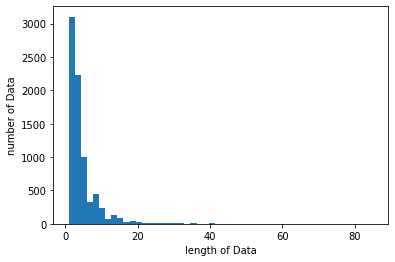

In [320]:
print('리뷰의 최대 길이 : {}'.format(max_len))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, sequences)) / len(sequences))) 

plt.hist([len(s) for s in sequences], bins = 50)
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

In [321]:
from keras.datasets import reuters 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding 
from keras.preprocessing import sequence 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

In [322]:
print(np.min(data_Y))
print(np.max(data_Y))

1
10


In [323]:
print("max_len : ", max_len)

max_len :  85


In [324]:
X = pad_sequences(sequences, maxlen = 6, truncating = 'post')
y = np_utils.to_categorical(data_Y)

In [325]:
X

array([[  0,   0,   0,   0, 184,  15],
       [ 85,  95,   1,  15,  19,  92],
       [  0,   0,   0, 217, 218, 100],
       ...,
       [  0,   0,   0,   0,   0, 358],
       [ 22,   1, 303,  71,  31,  98],
       [  0,   0,   0,   0, 483, 129]])

In [326]:
print(y)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [327]:
print(X.shape)
print(y.shape)

(7889, 6)
(7889, 11)


### 훈련/테스트용 데이터 분할

In [328]:
from sklearn.model_selection import train_test_split

In [329]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 777, stratify = y)

In [330]:
from tensorflow.keras.utils import to_categorical

In [331]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
# y_train = np.asarray(to_categorical(y_train))
# y_test = np.asarray(to_categorical(y_test))
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [332]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [333]:
# 0번째 지우기
y_train = y_train[:, 1:]
print(y_train)

y_test = y_test[:, 1:]
print(y_test)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [334]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6311, 6)
(6311, 10)
(1578, 6)
(1578, 10)


In [335]:
X_train

array([[130,  83,  40, 103, 376,  43],
       [  0,   6,  61,   4, 359,   1],
       [ 50, 105,  85,  87, 106, 367],
       ...,
       [  0,   0,   0,   1, 464,   1],
       [ 23,   3,   6,  13,  44,   5],
       [  0,   0,   0,   0,   0,   6]])

## 모델 구축

### 인공신경망을 제작합니다.

In [336]:
from tensorflow.keras.layers import Dense, GRU, Embedding

In [337]:
embedding_dim = 6
hidden_units = 512

In [338]:
vocab_size = len(word_index)
print(vocab_size)

1388


#### LSTM -> GRU

In [397]:
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim))
model.add(GRU(hidden_units))
# model.add(LSTM(6))
model.add(Dense(10, activation = 'softmax'))

#### 컴파일

In [398]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',  metrics = ['accuracy'])

#### 신경망 학습시키기

In [399]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

In [400]:
history = model.fit(X_train, y_train, epochs = 6,
                   validation_data = (X_test, y_test),
                   callbacks = [early_stop])

Epoch 1/6
198/198 [==============================] - 6s 24ms/step - loss: 1.4797 - accuracy: 0.6023 - val_loss: 1.3931 - val_accuracy: 0.6046
Epoch 2/6
198/198 [==============================] - 4s 21ms/step - loss: 1.3582 - accuracy: 0.6089 - val_loss: 1.3652 - val_accuracy: 0.6147
Epoch 3/6
198/198 [==============================] - 5s 23ms/step - loss: 1.3170 - accuracy: 0.6153 - val_loss: 1.3467 - val_accuracy: 0.6160
Epoch 4/6
198/198 [==============================] - 4s 22ms/step - loss: 1.2964 - accuracy: 0.6199 - val_loss: 1.4189 - val_accuracy: 0.6160
Epoch 5/6
198/198 [==============================] - 4s 22ms/step - loss: 1.2863 - accuracy: 0.6230 - val_loss: 1.3503 - val_accuracy: 0.6134
Epoch 6/6
198/198 [==============================] - 4s 21ms/step - loss: 1.2779 - accuracy: 0.6235 - val_loss: 1.3509 - val_accuracy: 0.6204


### 모델 성능 그래프로 출력

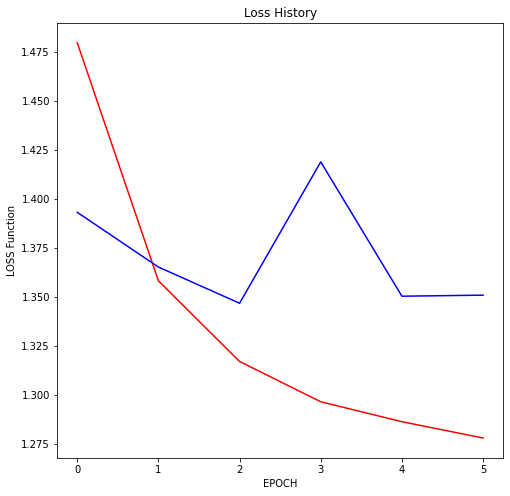

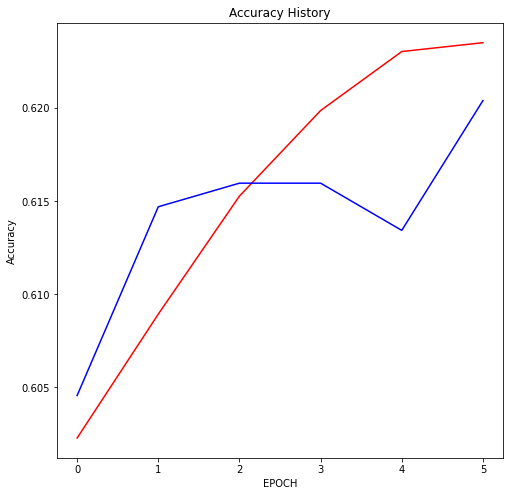

In [403]:
train_history = history.history["loss"]
validation_history = history.history["val_loss"]
fig = plt.figure(figsize=(8, 8))
plt.title("Loss History")
plt.xlabel("EPOCH")
plt.ylabel("LOSS Function")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')
# fig.savefig("train_history.png")

train_history = history.history["accuracy"]
validation_history = history.history["val_accuracy"]
fig = plt.figure(figsize=(8, 8))
plt.title("Accuracy History")
plt.xlabel("EPOCH")
plt.ylabel("Accuracy")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')
# fig.savefig("accuracy_history.png")

In [223]:
model.save('test_model.h5')

In [346]:
model.evaluate(X_test, y_test)[1]

50/50 [==============================] - 0s 6ms/step - loss: 1.3715 - accuracy: 0.6204


0.6204055547714233

## 평점 테스트

In [349]:
text_list = []

In [350]:
text_list.append("한 마디로 ‘치유’의 과정") # 8점
text_list.append("감동입니다..너무 재미있어용") # 걍 내가 쓴거
text_list.append("최악 !! 다신 안본다.") # 최악 들어간거 1점이었던듯,,,
text_list.append("처음엔 좋았으나 갈수록 보기거북함") # 5점
text_list.append("사형수는 개뿔, 죄없는 애들 속여서 끌고간거라고! 유족들은 억울함도 못풀었는데….이런식으로 팔아먹었어야 했냐? 감독 진짜 양심 터졌구나.") # 1점

In [351]:
# 명사만 추출하기
text_list_pos = []

for text in text_list:
    text_list_data = komoran.nouns(text)
    
    # 불용어 제거
    result_list = [word for word in text_list_data if not word in stopwords]
    
    text_list_pos.append(result_list)

In [352]:
text_list_pos

[['마디', '치유', '과정'],
 ['감동'],
 ['최악', '!!'],
 ['처음', '보기', '거북'],
 ['사형수', '개뿔', '죄', '애', '고간', '거', '유족', '식', '감독', '양심']]

In [353]:
sequences_test = tokenizer.texts_to_sequences(text_list_pos)
sequences_test

[[374], [7], [121], [22], [886, 84, 5, 731, 220, 17]]

In [354]:
sequences_test = pad_sequences(sequences_test, maxlen = 6)
sequences_test

array([[  0,   0,   0,   0,   0, 374],
       [  0,   0,   0,   0,   0,   7],
       [  0,   0,   0,   0,   0, 121],
       [  0,   0,   0,   0,   0,  22],
       [886,  84,   5, 731, 220,  17]])

In [355]:
res_test = model.predict(sequences_test)
res_test

array([[2.99953930e-02, 1.62449833e-02, 2.20267801e-03, 1.59081109e-02,
        9.01206490e-03, 2.82435417e-02, 3.62185203e-02, 7.80075192e-02,
        6.22022673e-02, 7.21964896e-01],
       [6.04593288e-03, 3.13408137e-03, 5.23763301e-04, 4.80752345e-03,
        2.65386538e-03, 9.01611429e-03, 1.23556638e-02, 3.23352776e-02,
        3.94872725e-02, 8.89640510e-01],
       [2.81390429e-01, 1.85722604e-01, 1.57237798e-02, 5.82490526e-02,
        3.77905145e-02, 8.76219794e-02, 9.91368070e-02, 1.28704965e-01,
        3.46192718e-02, 7.10405856e-02],
       [2.49536242e-02, 1.41818263e-02, 2.05267034e-03, 1.46063324e-02,
        8.55957344e-03, 2.59821638e-02, 3.37130092e-02, 7.35521615e-02,
        6.06097467e-02, 7.41788805e-01],
       [1.48358509e-01, 1.12034045e-01, 3.94670293e-02, 7.64286816e-02,
        6.58920780e-02, 9.74832997e-02, 1.03442214e-01, 1.34331942e-01,
        7.46769384e-02, 1.47885263e-01]], dtype=float32)

In [356]:
score_res = []

for a in res_test:
    score_res.append(np.argmax(a))
    
score_res

[9, 9, 0, 9, 0]

##### 리뷰데이터 별점으로 표기

In [402]:
score_list = []
b_star = "★"
w_star = "☆"

print("\n\n")
for i in range(len(text_list)):
    score1 = b_star * (score_res[i] + 1) # 별점 (검은하트)
    score2 = w_star * (10 - (score_res[i] + 1)) # 빈하트
    score = score1 + score2
    print("====================================================================================================================================")
    print(i + 1, "번째 리뷰\n")
    print(text_list[i])
    print("평점 : ", score, (score_res[i] + 1))
print("====================================================================================================================================")




1 번째 리뷰

한 마디로 ‘치유’의 과정
평점 :  ★★★★★★★★★★ 10
2 번째 리뷰

감동입니다..너무 재미있어용
평점 :  ★★★★★★★★★★ 10
3 번째 리뷰

최악 !! 다신 안본다.
평점 :  ★☆☆☆☆☆☆☆☆☆ 1
4 번째 리뷰

처음엔 좋았으나 갈수록 보기거북함
평점 :  ★★★★★★★★★★ 10
5 번째 리뷰

사형수는 개뿔, 죄없는 애들 속여서 끌고간거라고! 유족들은 억울함도 못풀었는데….이런식으로 팔아먹었어야 했냐? 감독 진짜 양심 터졌구나.
평점 :  ★☆☆☆☆☆☆☆☆☆ 1
